<a href="https://colab.research.google.com/github/chirucodes/aiml/blob/main/ResNet50_ImageCaptioningGroup4_BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reference Links to follow

In [ ]:
# https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/

# https://rupamgoyal12.medium.com/image-caption-generator-using-resnet50-and-lstm-model-a5b11f60cd23


### Download dataset and unzip

In [1]:
!rm -rf Flickr8k_Dataset.zip
!rm -rf Flickr8k_text.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430

### Import Modules

In [ ]:
"""
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import optimizers
from keras import Input, layers

from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
"""
# from keras.applications.inception_v3 import preprocess_input


In [ ]:
"""
# from keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
"""


'\n# from keras.optimizers import Adam, RMSprop\nfrom tensorflow.keras.utils import to_categorical\nfrom tensorflow.keras.optimizers import Adam, RMSprop\n'

In [ ]:

#  as app
# .resnet50 import preprocess_input 
# ResNet50, resnet50

# dir(app)



In [2]:
import glob
from keras.preprocessing import image
import numpy as np
# from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input 
from tensorflow.keras.applications.resnet50 import ResNet50
# from keras.applications.inception_v3 import InceptionV3
# form tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input 
# ResNet50
from keras.models import Model


In [3]:
from time import time

### Image feature extractor


##### Defining source variables and initialise train test images list

In [4]:
# Below path contains all the images
images = '/content/Flicker8k_Dataset/'

# Below file conatains the names of images to be used in train data
train_images_file = '/content/Flickr_8k.trainImages.txt'

# Below file conatains the names of images to be used in test data
test_images_file = '/content/Flickr_8k.testImages.txt'

In [5]:
# Train + Test
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [6]:
type(img), img[:5]

(list,
 ['/content/Flicker8k_Dataset/1453366750_6e8cf601bf.jpg',
  '/content/Flicker8k_Dataset/2158267555_db1d94e468.jpg',
  '/content/Flicker8k_Dataset/484896012_7787d04f41.jpg',
  '/content/Flicker8k_Dataset/3677734351_63d60844cb.jpg',
  '/content/Flicker8k_Dataset/756521713_5d3da56a54.jpg'])

In [7]:
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
type(train_images), len(train_images), list(train_images)[:5]

(set,
 6000,
 ['3134387513_ceb75bea0a.jpg',
  '2911107495_e3cec16a24.jpg',
  '2867937005_91c092b157.jpg',
  '2661437618_ca7a15f3cb.jpg',
  '2855594918_1d1e6a6061.jpg'])

In [8]:
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

type(test_images), len(test_images), list(test_images)[:5]

(set,
 1000,
 ['3250695024_93e8ab7305.jpg',
  '2170222061_e8bce4a32d.jpg',
  '2526585002_10987a63f3.jpg',
  '3316725440_9ccd9b5417.jpg',
  '1472230829_803818a383.jpg'])

In [9]:
images

'/content/Flicker8k_Dataset/'

In [10]:
# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

type(train_img), len(train_img), train_img[:5]

(list,
 6000,
 ['/content/Flicker8k_Dataset/1453366750_6e8cf601bf.jpg',
  '/content/Flicker8k_Dataset/484896012_7787d04f41.jpg',
  '/content/Flicker8k_Dataset/3677734351_63d60844cb.jpg',
  '/content/Flicker8k_Dataset/942399470_6132d3e5d2.jpg',
  '/content/Flicker8k_Dataset/362316425_bda238b4de.jpg'])

In [11]:
# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

type(test_img), len(test_img), test_img[:5]

(list,
 1000,
 ['/content/Flicker8k_Dataset/2932740428_b15384f389.jpg',
  '/content/Flicker8k_Dataset/2239938351_43c73c887c.jpg',
  '/content/Flicker8k_Dataset/2396691909_6b8c2f7c44.jpg',
  '/content/Flicker8k_Dataset/3585598356_8ce815bbb9.jpg',
  '/content/Flicker8k_Dataset/3186412658_2ab2ebd397.jpg'])

##### Scrap

In [12]:
# import  as kl
from keras.layers import Dense, Dropout

In [13]:
sorted(dir(kl))

NameError: ignored

In [ ]:
# For learning trainable, non_trainable
import keras
from keras import Input
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

print(Dense)
# exit(1)

layer = Dense(2)
# layer = Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

print("--------------------------------")


"""
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
"""

##### Common methods for preprocessing the images with ResNet50

###### Normalization

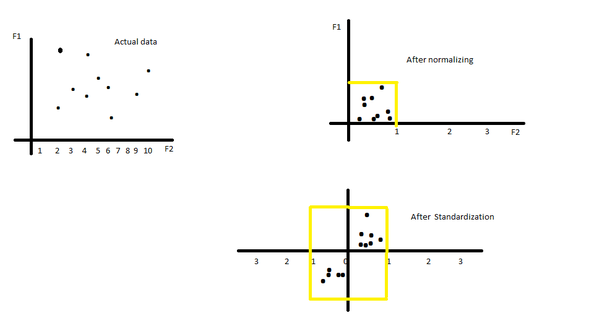

In [14]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model(To be replaced with ResNet50)
    # from keras.preprocessing import image

    # img = image.load_img(image_path, target_size=(299, 299))
    img = image.load_img(image_path, target_size=(224, 224))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    # from keras.applications.inception_v3 import preprocess_input
    # from keras.applications.resnet50 import preprocess_input 
    x = preprocess_input(x)
    return x

In [15]:
# model = InceptionV3(weights='imagenet')

model = ResNet50(weights='imagenet')


102981632/102967424 [==============================] - 1s 0us/step


In [16]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [17]:
# Create a new model, by removing the last layer (output layer) from the ResNet50
model_new = Model(model.input, model.layers[-2].output)

#What is the output of the model here
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [18]:
len(model.layers)

177

In [19]:
len(model_new.layers)

176

In [20]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image - user defined method
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [21]:
encode(train_img[0])
# train_img[0]

array([1.9448909 , 2.153307  , 0.04631646, ..., 0.26168475, 0.25865525,
       0.01581944], dtype=float32)

##### Get feature vectors for train images

In [22]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 334.4997248649597


In [23]:
key1, val1 = list(encoding_train.items())[0]
type(encoding_train), len(encoding_train.keys())


(dict, 6000)

In [24]:
val1.shape

(2048,)

##### Get feature vectors for test images

In [25]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 54.90520763397217


In [26]:
key1, val1 = list(encoding_train.items())[0]
type(encoding_train), len(encoding_train.keys()), val1.shape


(dict, 6000, (2048,))

##### Dump the feature vectors of train and test images into a file using pickle mechanism

In [27]:
from pickle import dump, load

In [28]:
!mkdir "/content/sample_data/Pickle"
pkl_train_file="/content/sample_data/Pickle/encoded_train_images.pkl"
pkl_test_file = "/content/sample_data/Pickle/encoded_test_images.pkl"

In [29]:
# Save the bottleneck train features to disk
with open(pkl_train_file, "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [30]:

# Save the bottleneck test features to disk
with open(pkl_test_file, "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

### Text Preprocessor


#### Loading the text from given dataset into workspace

In [31]:
filename = "/content/Flickr8k.token.txt"

In [32]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


In [33]:

# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [34]:
# Prepare a dict of Image key and image specific descriptions

def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping


In [35]:
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [36]:
type(descriptions), list(descriptions.items())[0]

(dict,
 ('1000268201_693b08cb0e',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .']))

In [37]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [38]:
descriptions['10815824_2997e03d76'][2]

"A girl holding a horse 's lead behind a fire ."

#### Clean up the text

In [39]:
import string


In [40]:
# prepare translation table for removing punctuation
# tokenize
# convert to lower case
# remove punctuation from each token
# remove hanging 's' and 'a'
# remove tokens with numbers in them
# store as string


def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)


In [41]:

# clean descriptions
clean_descriptions(descriptions)

In [42]:
descriptions['10815824_2997e03d76'][2]


'girl holding horse lead behind fire'

#### Prepare vocabulary of words

In [43]:
# convert the loaded descriptions into a vocabulary of words - vow
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc


In [44]:

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [45]:
type(vocabulary), list(vocabulary)[:5]

(set, ['plywood', 'shit', 'witnesses', 'drooping', 'swing'])

#### Dump / Write all the descriptions into a file
- [image1] [description1]
- [image2] [description2]
- [image3] [description3]

In [46]:

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [47]:

save_descriptions(descriptions, 'descriptions.txt')


#### Train and test sets


In [48]:
# Below file conatains the names of images to be used in train data
# filename = '/content/Flickr_8k.trainImages.txt'
train_images_file = '/content/Flickr_8k.trainImages.txt'

# Below file conatains the names of images to be used in test data
test_images_file = '/content/Flickr_8k.testImages.txt'

# Below path contains all the images
images = '/content/Flicker8k_Dataset/'

In [49]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)


In [50]:
# load training dataset (6K)
train = load_set(train_images_file)
print('Dataset: %d' % len(train))

Dataset: 6000


In [51]:
list(train)[:5]

['2561319255_ce5ede291e',
 '2191329761_3effd856c5',
 '405331006_4e94e07698',
 '3336374196_f6eaca542f',
 '1313693129_71d0b21c63']

In [52]:
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [53]:
type(img), img[:5]

(list,
 ['/content/Flicker8k_Dataset/1453366750_6e8cf601bf.jpg',
  '/content/Flicker8k_Dataset/2158267555_db1d94e468.jpg',
  '/content/Flicker8k_Dataset/484896012_7787d04f41.jpg',
  '/content/Flicker8k_Dataset/3677734351_63d60844cb.jpg',
  '/content/Flicker8k_Dataset/756521713_5d3da56a54.jpg'])

In [54]:

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [55]:

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

#### Map train images and train descriptions

In [56]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions


In [57]:
type(train), len(train), list(train)[:5]


(set,
 6000,
 ['2561319255_ce5ede291e',
  '2191329761_3effd856c5',
  '405331006_4e94e07698',
  '3336374196_f6eaca542f',
  '1313693129_71d0b21c63'])

In [58]:

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [59]:
list(train_descriptions.items())[0]

('1000268201_693b08cb0e',
 ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'])

### Load all the captions and prepare 
1.   word_dict
2.   ixtoword
3.   wordtoix

In [60]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
    # if True:
        # break
len(all_train_captions) #, all_train_captions

30000

In [61]:
#To Check if there are any duplicate captions in train description. there are 232 duplicate entries
type(all_train_captions), len(all_train_captions), len(set(all_train_captions)), len(all_train_captions) - len(set(all_train_captions)) 

(list, 30000, 29768, 232)

In [62]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words [Actual words] %d -> [Words which are having >= 10 threshold] %d' % (len(word_counts), len(vocab)))

preprocessed words [Actual words] 7578 -> [Words which are having >= 10 threshold] 1651


In [63]:
vocab[:5]

['startseq', 'child', 'in', 'pink', 'dress']

In [64]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [65]:
list(wordtoix.items())[:5], list(ixtoword.items())[:5]

([('startseq', 1), ('child', 2), ('in', 3), ('pink', 4), ('dress', 5)],
 [(1, 'startseq'), (2, 'child'), (3, 'in'), (4, 'pink'), (5, 'dress')])

In [66]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

#### Find max sequence length

In [67]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)


In [68]:

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


### Output predictor


### Fitting the Model


### Caption Geneartion

### Load Files and Contents into the workspace

### Clean up the input data


### Load all the captions and prepare 
1.   word_dict
2.   ixtoword
3.   wordtoix

### DataLoader with batches